Assignment 2 : It’s difficult to fathom just how vast and diverse our natural world is. There are over 5,000 species of mammals, 10,000 species of birds, 30,000 species of
fish – and astonishingly, over 400,000 different types of flowers.
In this competition, you’re challenged to build a machine learning model that
identifies the type of flowers in a dataset of images (for simplicity, we’re sticking to
just over 100 types). Dataset link: https://www.kaggle.com/c/tpu-getting-started/data

In [1]:
#Importing Dependencies

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import re
import math

In [2]:
import tensorflow as tf 
from kaggle_datasets import KaggleDatasets 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.2


In [3]:
# Detect TPU, return appropriate distribution strategy

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() 

In [5]:
# For IMAGE_SIZE=[192, 192], a GPU will run out of memory, hence use TPU 
IMAGE_SIZE = [192, 192] 
EPOCHS = 5 
BATCH_SIZE = 16 * strategy.num_replicas_in_sync 

NUM_TRAINING_IMAGES = 12753 
NUM_TEST_IMAGES = 7382 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE 
AUTO = tf.data.experimental.AUTOTUNE 

**Dataset Helper Function**

In [6]:
def decode_image(image_data): 
    image = tf.image.decode_jpeg(image_data, channels=3) 
    # Converting image to floats in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0 
    # explicit size needed for TPU. Reshaping the data so that all the images are of same shape
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image 

In [7]:
def read_labeled_tfrecord(example): 
    LABELED_TFREC_FORMAT = {
        # tf.io.FixedLenFeature ==> Configuration for parsing a fixed-length input feature.
        "image": tf.io.FixedLenFeature([], tf.string), # shape [] ==> single element, tf.string ==> bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT) 
    image = decode_image(example['image']) 
    label = tf.cast(example['class'], tf.int32) 
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example): 
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string),
        # class is missing, 
        # this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT) 
    image = decode_image(example['image']) 
    idnum = example['id'] 
    return image, idnum # returns a dataset of image(s)

In [8]:
def load_dataset(filenames, labeled=True, ordered=False): 
    # Read from TFRecords. 
    # For optimal performance, reading from multiple files at once and disregarding data order. 
    # Order does not matter since we will be shuffling the data anyway.
    
    ignore_order = tf.data.Options()
    if not ordered: 
        ignore_order.experimental_deterministic = False # disable order, increase speed 
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    # num_parallel_reads=AUTO ==> Number of files to read in parallel
    # automatically interleaves reads from multiple files
    
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO) 
    # num_parallel_calls=AUTO ==> This loads multiple datasets in parallel, reducing the time waiting for the files to be opened.
    
    return dataset
    # returns a dataset of 
    # (image, label) pairs if labeled=True 
    # OR 
    # (image, id) pairs if labeled=False

In [9]:
from kaggle_datasets import KaggleDatasets
# google cloud store path
PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(PATH)

gs://kds-63abd6282bf5d32d6106a5a41d26af6cb4401d432680050543462312


In [10]:
# paths 
TRAINING_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/train/*.tfrec')
VALID_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/val/*.tfrec')
TEST_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/test/*.tfrec')

2023-02-22 10:56:56.850217: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [11]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [12]:
# Helper variables
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SHAPE = [512,512]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 5

In [13]:
def decode_image(img):
    '''Load Image From The Dataset'''
    image = tf.io.decode_jpeg(img,channels=3)
    image = tf.cast(image,tf.float32)/255.0
    image = tf.reshape(image,[*IMAGE_SHAPE,3])
    return image

In [14]:
def read_labeled_data(example):
    '''Read Labeled tfrecord'''
    labeled_struct = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'class': tf.io.FixedLenFeature([],tf.int64)
    }
    parsed = tf.io.parse_single_example(example,labeled_struct)
    image = decode_image(parsed['image'])
    label = tf.cast(parsed['class'],tf.int32)
    return image,label

In [15]:
def read_unlabeled_data(example):
    '''Read unlabeled tfrecord'''
    unlabeled_struct = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'id':tf.io.FixedLenFeature([],tf.string)
    }
    parsed = tf.io.parse_single_example(example,unlabeled_struct)
    image = decode_image(parsed['image'])
    idnum = parsed['id']
    return image,idnum

In [16]:
def load_dataset(filenames,is_labeled = True,inorder=False):
    '''Load the tfrecord as Dataset.
    is_label(bool) : is the data labeled or unlabeled
    inorder(bool) : Should the data be inorder or loaded as soon as it arrives'''
    options = tf.data.Options()
    if not inorder:
        options.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
    dataset = dataset.with_options(options)
    dataset = dataset.map(read_labeled_data if is_labeled else read_unlabeled_data)
    return dataset

In [17]:
def data_aug(image,label):
    '''Image Augummentation'''
    image = tf.image.random_flip_left_right(image)
    return image,label

In [18]:
def get_training_data():
    '''Load the training dataset'''
    dataset = load_dataset(TRAINING_IMAGES,is_labeled=True)
    dataset = dataset.map(data_aug,num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(49)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [19]:
def get_valid_data():
    '''Load the validation dataset'''
    dataset = load_dataset(VALID_IMAGES,is_labeled=True,inorder=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [20]:
def get_test_data(ordered=False):
    '''Load the test dataset'''
    dataset = load_dataset(TEST_IMAGES,is_labeled=False,inorder=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [21]:
def count_files(filenames):
    '''Count number of files in the dataset'''
    n = [int(re.compile(r"-([0-9]*)\.").search(file).group(1)) for file in filenames]
    return np.sum(n)

In [22]:
import re
NUM_TRAIN_IMG = count_files(TRAINING_IMAGES)
NUM_VALID_IMG = count_files(VALID_IMAGES)
NUM_TEST_IMG = count_files(TEST_IMAGES)
print(f'Number of training images : {NUM_TRAIN_IMG} \nNumber of validation images : {NUM_VALID_IMG} \nNumber of test images : {NUM_TEST_IMG}')

Number of training images : 12753 
Number of validation images : 3712 
Number of test images : 7382


In [23]:
# get the data
ds_train = get_training_data()
ds_valid = get_valid_data()
ds_test = get_test_data()

2023-02-22 10:56:58.235095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-22 10:56:58.235170: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


**EDA**

In [24]:
def batch_to_numpy(data):
    '''Converts batch of data to numpy '''
    image , label = data
    image = image.numpy()
    label = label.numpy()
    if label.dtype == object:
        label = [None for _ in enumerate(label)]
    return image , label

In [25]:
def display_batch_images(databatch):
    '''Plots Some Train , Test , Validation data'''
    # load data as numpy 
    img,label = batch_to_numpy(databatch)
    
    rows = int(math.sqrt(len(img)))
    cols = len(img)//rows
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
        
    for i , (image, label) in enumerate(zip(img[:rows*cols],label[:rows*cols])):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        plt.imshow(image)
        if label:
            plt.title(CLASSES[label])
        plt.tight_layout()
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
        

2023-02-22 10:57:01.913326: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


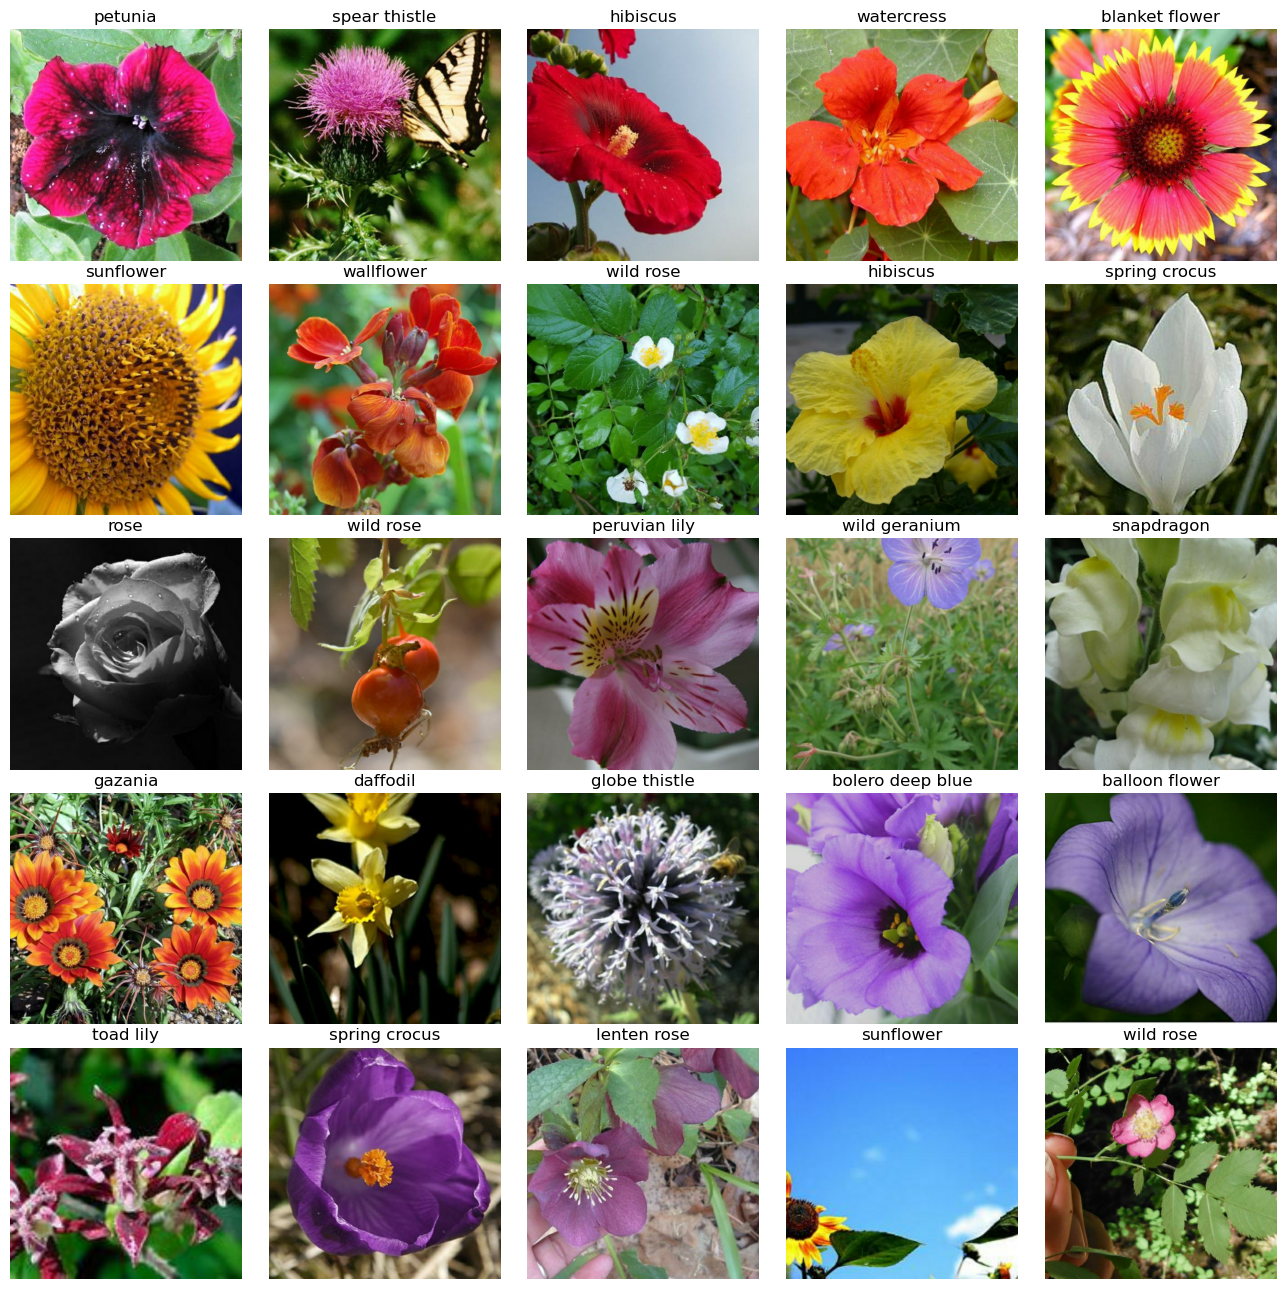

In [26]:
display_batch_images(next(iter(ds_valid.unbatch().batch(25))))